# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [43]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque

In [44]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

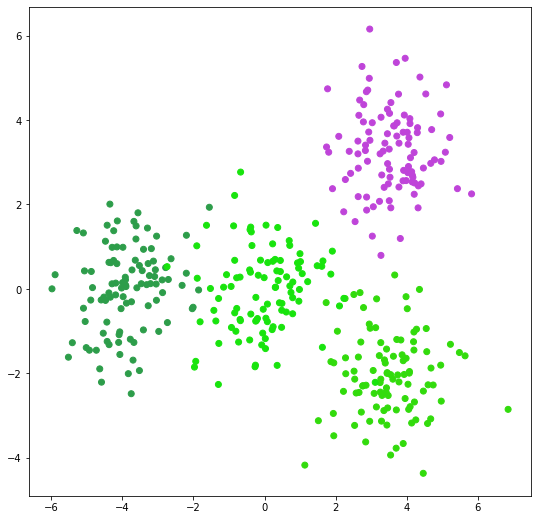

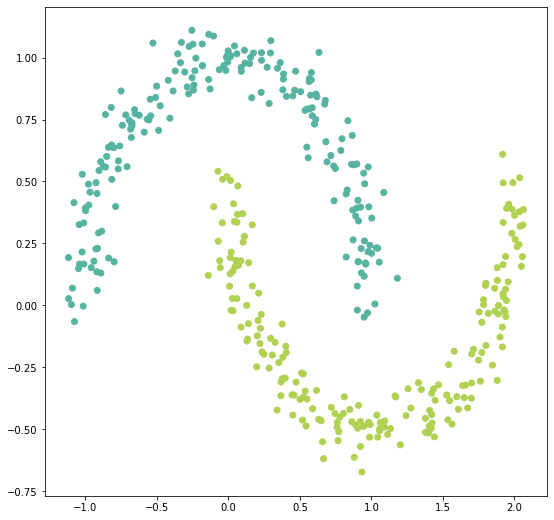

In [100]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [101]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = np.array([[]])

    def fit(self, X, y=None):
        if self.init == 'random':
            min_x, min_y = X.min(axis=0)
            max_x, max_y = X.max(axis=0)
            self.centroids = np.array([[random.uniform(min_x, max_x), random.uniform(min_y, max_y)] for i in range (self.n_clusters)])
        elif self.init == 'self.init == random':
            self.centroids = np.array([X[random.randint(0, len(X) - 1)] for i in range (self.n_clusters)])
        else:
#           посчитаем квадратые расстояний до ближайших центроидов - distances

            self.centroids = np.array([X[random.randint(0, len(X) - 1)]])
            while len(self.centroids) < self.n_clusters:
            
                distances = [(-1) for i in range (len(X))]
                sum_of_dist = 0
                
                for index in range(len(X)):
                    for c in self.centroids: 
                        cur_dist = (c[0] - X[index][0]) ** 2 + (c[1] - X[index][1]) ** 2
                        if distances[index] == -1 or distances[index] > cur_dist:
                            distances[index] = cur_dist
                    sum_of_dist += distances[index]
#                пропорционально квадрату расстояния выберем следующий центроид
                random_pointer = random.uniform(0, sum_of_dist)
                sum_of_dist = 0
                index_of_new_centroid = -1
            
                while sum_of_dist < random_pointer:
                    index_of_new_centroid += 1
                    sum_of_dist+=distances[index_of_new_centroid]
                self.centroids = np.append(self.centroids, [X[index_of_new_centroid]], axis=0)
            
    def predict(self, X):
#         X_clusters[i] - номер кластера, к которому относится i-й элемент
        X_clusters = [(-1) for i in range (len(X))]
        for i in range(self.max_iter):
    #         Относим каждую точку к ближайшему для нее кластеру
            for index in range(len(X)):
                cluster_index = 0
                min_dist = -1
                for c_in in range(len(self.centroids)): 
                    cur_dist = (self.centroids[c_in][0] - X[index][0]) ** 2 + (self.centroids[c_in][1] - X[index][1]) ** 2
                    if min_dist == -1 or min_dist > cur_dist:
                        min_dist = cur_dist
                        cluster_index = c_in
                X_clusters[index] = cluster_index
    #         Двигаем центры кластеров в центры масс
            cluster_coord_sum = np.array([[0, 0] for i in range (self.n_clusters)])
            cluster_amount_of_dots = np.array([0 for i in range (self.n_clusters)])
            for i in range(len(X_clusters)):
                cluster_coord_sum[X_clusters[i]][0] += X[i][0]
                cluster_coord_sum[X_clusters[i]][1] += X[i][1]
                cluster_amount_of_dots[X_clusters[i]] += 1
            self.centroids = (cluster_coord_sum.transpose() / cluster_amount_of_dots).transpose()
        return X_clusters
        
            

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

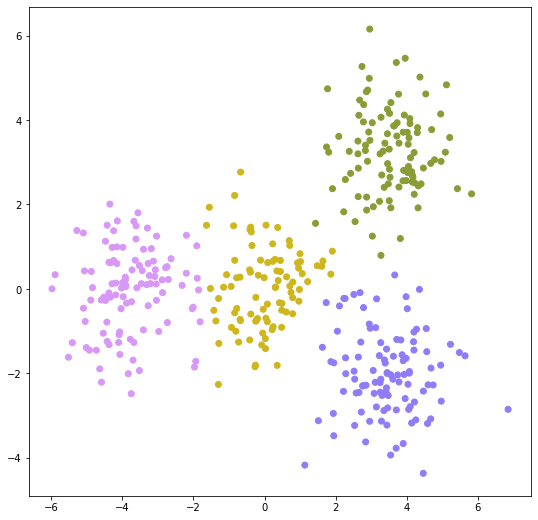

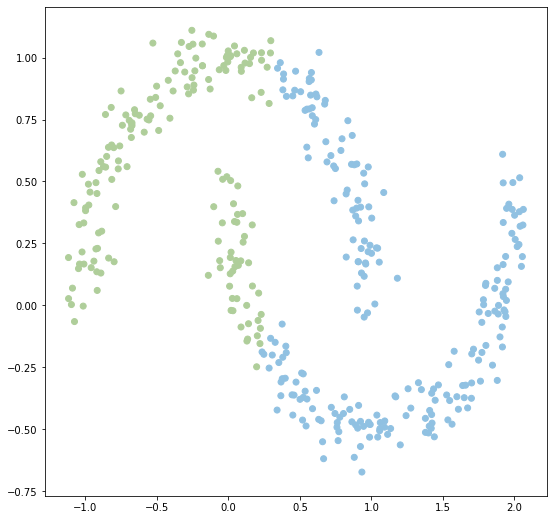

In [105]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [ ]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        raise NotImplementedError()
        
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan()
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [ ]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)